<a href="https://colab.research.google.com/github/aidan-plenert-macdonald/physics/blob/master/Fractional_Brownian_Motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo

Because the first value of the process is fixed, there is a degeneracy in the covariance matrix. We can fix this by getting the stepwise covariance.

$$\begin{align}
\Delta B_t &= B_{t + \Delta t} - B_t \\
2 \mathbb{E} [ \Delta B_t \Delta B_s ] &= 2 | t - s |^{2H} - | t + \Delta t - s |^{2H} - | t - s - \Delta t |^{2H}
\end{align}$$

In the limit $ \Delta t \rightarrow 0 $, the [Taylor expansion](https://goo.gl/2tgNj4)

$$\begin{align}
2 \mathbb{E} [ \Delta B_t \Delta B_s ] &= -2H(2H-1) | t - s |^{2(H-1)} \Delta t^2 + \mathcal{O}(\Delta t^4)
\end{align}$$

Imagine we want to extrapolate an existing series. We can find the p.d.f. of the next point in time by considering $ \vec{b}_n = \Delta B_{n\Delta t} $ and,

$$\begin{align}
\Gamma_{n-m} &= \mathbb{E}[ \Delta B_{n\Delta t} \Delta B_{m \Delta t} ] \\
  &= \left[ 2 | n - m |^{2H} - | n - m +1 |^{2H} - | n - m - 1|^{2H} \right]
\end{align}$$

This diagonalizes nicely in the Fourier basis where the transform is $ \hat{F}_{kn} = N^{-1/2} e^{-i 2 \pi ~ kn/N} \triangleq N^{-1/2} z^{-kn}~~ \forall ~ 0 \leq n, k \leq N-1 $.

$$\begin{align}
\hat{F}_{kn} \Gamma_{n-m} \hat{F}_{\ell m}^\dagger &= \hat{F}_{kn} \left( N^{-2} \sum_{r=0}^{N-1} z^{r(n-m)} \sum_{a,b=0}^{N-1} z^{-r(a-b)} ~ \Gamma_{a-b} \right) \hat{F}_{\ell m}^\dagger \\
  &= \hat{F}_{kn} \left( N^{-2} \sum_{r=0}^{N-1} z^{r(n-m)} \sum_{h=1-N}^{N-1} z^{-rh} ~ (N- |h|) \Gamma_h \right) \hat{F}_{\ell m}^\dagger \\
  &= N^{-3} \sum_{r=0}^{N-1} \sum_{h=1-N}^{N-1} z^{-rh} ~ (N- |h|) \Gamma_h \left( \sum_{n,m=0}^{N-1} z^{\ell m - kn} z^{r(n-m)} \right) \\
  &= N^{-3} \sum_{r=0}^{N-1} \sum_{h=1-N}^{N-1} z^{-rh} ~ (N- |h|) \Gamma_h \left( \sum_{n,m=0}^{N-1} z^{m(\ell - r)} z^{-n(k - r)} \right) \\
  &= N^{-3} \sum_{r=0}^{N-1} \sum_{h=1-N}^{N-1} z^{-rh} ~ (N- |h|) \Gamma_h \left( \sum_{n,m=-\infty}^{+\infty} N^2 \delta^{\text{kron}}[\ell - r - mN] ~ \delta^{\text{kron}}[k - r - nN] \right) \\
  &= N^{-1} \sum_{h=1-N}^{N-1} z^{-\ell h} ~ (N- |h|) \Gamma_h ~ \delta^{\text{kron}}[\ell - k] \\
\end{align}$$

Thus, the kth eigen vector is $ \vec{x}_k = z^kn $ with eigen value $ \lambda_k = N^{-1} \sum_{h=1-N}^{N-1} z^{-k h} ~ (N- |h|) \Gamma_h ~ \delta^{\text{kron}} $.

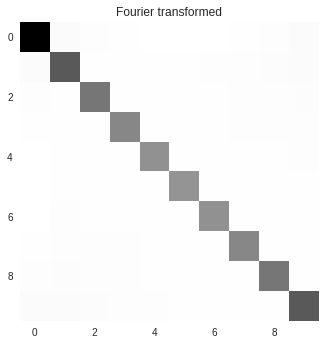

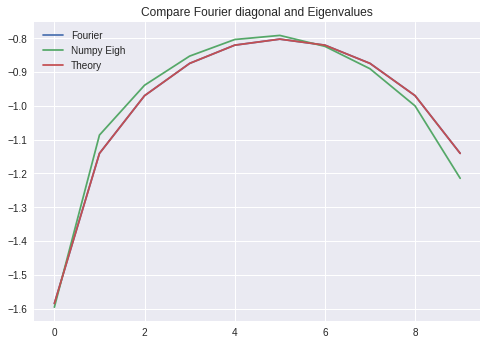

In [39]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

def G(N, H=0.25): # Gamma
  t = np.arange(N).reshape(-1, 1)
  return (2*np.abs(t - t.T)**(2*H) - np.abs(t - t.T + 1)**(2*H) - np.abs(t - t.T - 1)**(2*H))/2

N, H = 10, 0.6
n = np.arange(N).reshape(-1, 1)
k = n.T
F = np.exp(-1.0j * 2*np.pi * k * n / N) / N**0.5
assert np.allclose(np.real(np.diag(F.conj().T.dot(F))), 1.0), "F not orthogonal"

# Diagonalize the matrix
fG = F.dot(G(N, H)).dot(F.conj().T)
plt.imshow(np.abs(fG))
plt.title("Fourier transformed")
plt.grid(False)
plt.show()

# Theoretical Eigenvalues
h = np.arange(1-N, N).reshape(-1, 1)
k = np.arange(N).reshape(1, -1)
theory_vals = np.real(np.exp(-1.0j * 2*np.pi * k * h / N).T.dot(
  (N - np.abs(h)) * (
      2*np.abs(h)**(2*H) - np.abs(h+1)**(2*H) - np.abs(h-1)**(2*H)
  )
) / N).flatten()/2

# Experimental Eigenvalues
eig_vals, _  = eigh(G(N, H))
experi_vals = np.real(np.diag(fG))

assert np.allclose(experi_vals, theory_vals)

plt.title("Compare Fourier diagonal and Eigenvalues")

plt.plot(experi_vals)
plt.plot(np.hstack([eig_vals[0:-1:2], eig_vals[eig_vals.size:0:-2]]))
plt.plot(theory_vals)

plt.legend(["Fourier", "Numpy Eigh", "Theory"])
plt.show()




# Simple Simulator

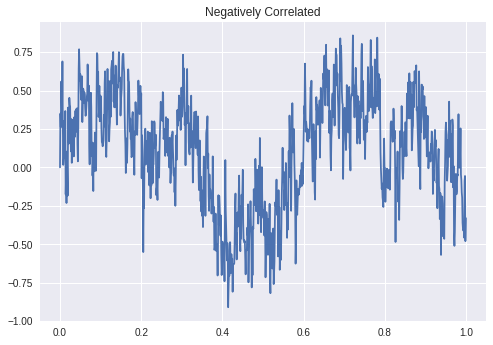

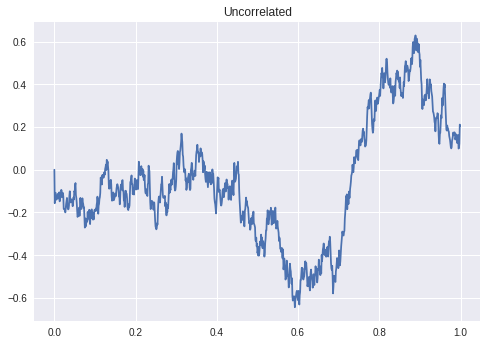

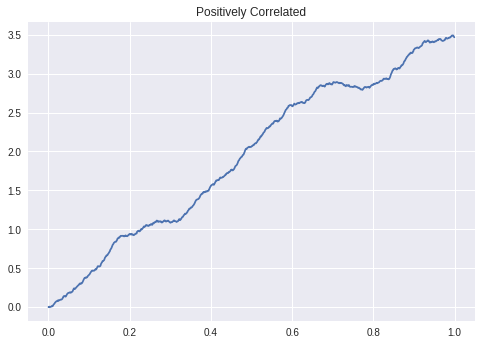

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

def simulate(t, H):
  t, s = t.copy().reshape(-1, 1), t.copy().reshape(1, -1)
  
  Gamma = (np.abs(s)**(2*H) + np.abs(t)**(2*H) - np.abs(t - s)**(2*H))/2
  
  return linalg.sqrtm(Gamma).dot(np.random.randn(*t.shape)).flatten()

t = np.arange(0, 1, 1e-3)

plt.plot(t, simulate(t, 0.25))
plt.title("Negatively Correlated")
plt.show()

plt.plot(t, simulate(t, 0.5))
plt.title("Uncorrelated")
plt.show()

plt.plot(t, simulate(t, 0.75))
plt.title("Positively Correlated")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


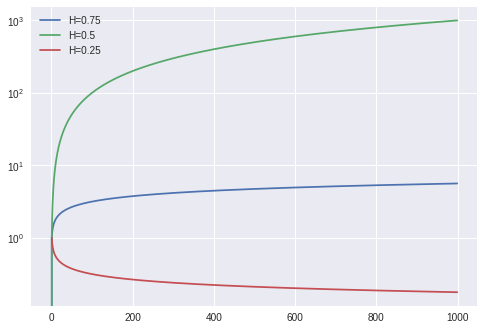

In [0]:
t = np.arange(t.shape[0])
plt.semilogy(t, t**0.25)
plt.semilogy(t, t)
plt.semilogy(t, t**(-0.25))

plt.legend(["H=0.75", "H=0.5", "H=0.25"])
plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


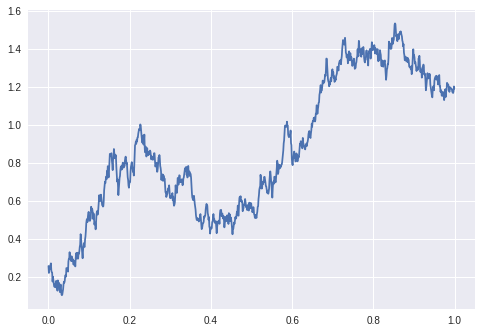

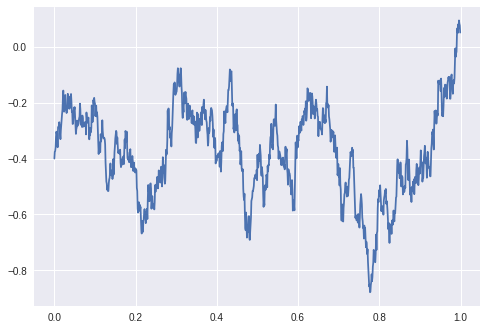

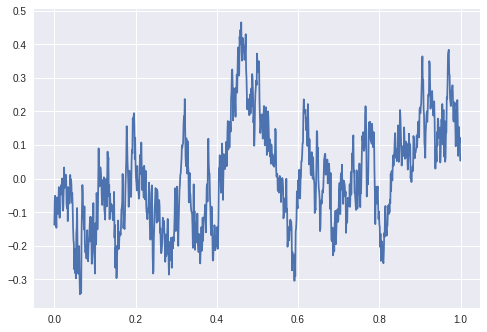

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

def simulate(t, t_shift):
  t, s = t.copy().reshape(-1, 1), t.copy().reshape(1, -1)
  
  f = lambda dt: np.abs(dt)**(np.tanh(dt - t_shift) + 1)/2
  Gamma = (f(s) + f(s) - f(t-s))/2
  
  return linalg.sqrtm(Gamma).dot(np.random.randn(*t.shape)).flatten()

t = np.arange(0, 1, 1e-3)

plt.plot(t, simulate(t, 0.01))
plt.show()

plt.plot(t, simulate(t, 0.1))
plt.show()

plt.plot(t, simulate(t, 0.25))
plt.show()

In [0]:
import numpy as np
from numpy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.linalg import circulant

def G(N, H=0.25): # Gamma
  t = np.arange(N).reshape(-1, 1)
  return (2*np.abs(t - t.T)**(2*H) - np.abs(t - t.T + 1)**(2*H) - np.abs(t - t.T - 1)**(2*H))/2

vals, vecs = eigh(G(4, 0.6))

ind = np.arange(vecs.shape[1])
vecs[:, 1:]/vecs[:, :-1]

array([[ 1.40096996, -0.89070186,  0.6178453 ],
       [ 0.6178453 ,  1.29705701,  1.40096996],
       [-0.6178453 , -1.29705701, -1.40096996],
       [-1.40096996,  0.89070186, -0.6178453 ]])

The eigenvectors are fairly sinusoidal, so perhaps a a transform would help. Numerically,

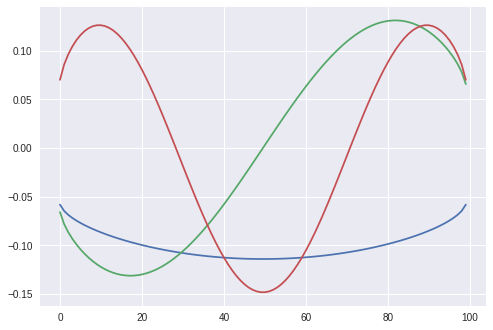

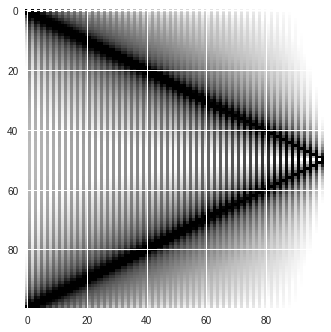

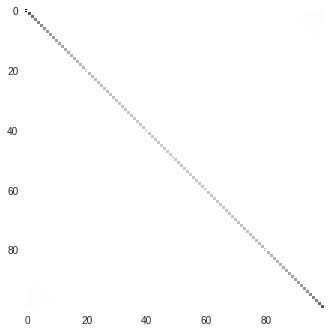

In [0]:
from numpy.linalg import pinv
from matplotlib.colors import LogNorm

N = 100
vals, vecs = eigh(G(N, 0.6))

plt.plot(vecs[:, :3])
plt.show()

plt.imshow(np.abs(np.fft.fft(vecs[:, :], axis=0)), norm=LogNorm(vmin=0.01, vmax=1))
plt.show()

n = np.arange(N).reshape(-1, 1)
k = n.T
F = np.exp(-1.0j * 2*np.pi * k * n / N) / N**0.5

fG = F.dot(G(N, 0.6)).dot(F.conj().T)
plt.imshow(np.abs(fG))
plt.show()

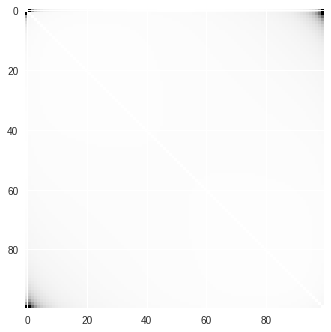

In [0]:
plt.imshow(np.abs(fG - np.diag(fG)*np.eye(N)))
plt.show()

We can transform our 

We can look at symmetries of this covariance matrix. Consider 2 operators on $ \mathbb{R}^{N\times N} $,

$$\begin{align}
M &= \left[\begin{matrix}
0 & ~ & 1 \\
~ & \dots \\
1 & ~ & 0 \\
\end{matrix}\right] ~~ \text{Reflection matrix} \\
R &= \left[\begin{matrix}
0 & 0 & \dots \\
0 & 1 &   \\
\vdots &  & \ddots \\
\end{matrix}\right] ~~ \text{Removal matrix} \\
S &= \left[\begin{matrix}
0 & 0 & \dots & 1 \\
1 & 0 &  \dots & 0 \\
0 & \ddots \\
\vdots & & 1 & 0
\end{matrix}\right] ~~ \text{Shift matrix} \\
\end{align}$$

By thinking about what the matrices do, you can construct a symmetry and algebraically reduce it using $ M^T \Gamma M = \Gamma $.

$$\begin{align}
\Gamma &= S^T R^T \Gamma R S + M^T ( \Gamma - R^T \Gamma R ) M \\
S^T R^T \Gamma R S &= M^T R^T \Gamma R M
\end{align}$$



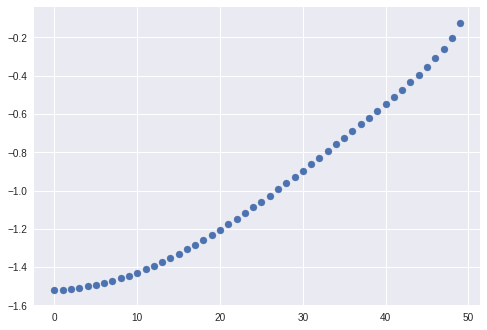

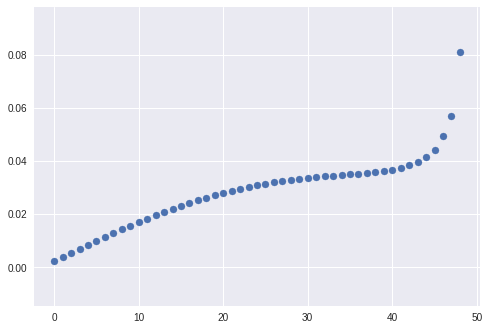

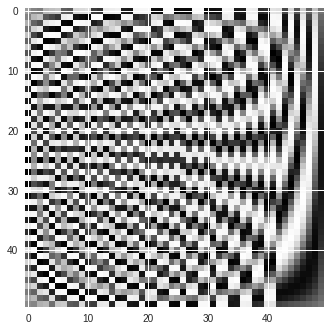

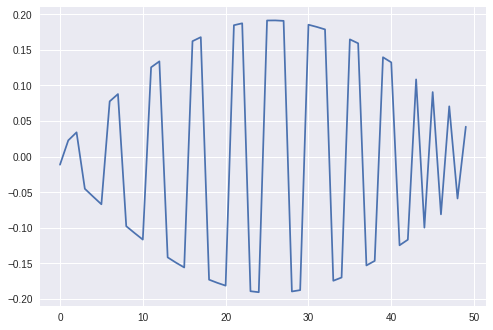

In [0]:
import numpy as np
from numpy.linalg import eigh
import matplotlib.pyplot as plt

N = 50
vals, vecs = eigh(G(N))
plt.scatter(np.arange(N), vals)
plt.show()

plt.scatter(np.arange(N-1), np.diff(vals))
plt.show()

plt.imshow(vecs)
plt.show()

plt.plot(vecs[:1, :].T)
plt.show()

In [0]:
def R(N):
  r = np.eye(N)
  r[0, :] = 0
  return r

S = lambda N: np.roll(np.eye(N), -1, axis=1)
M = lambda N: np.flip(np.eye(N), axis=0)

plt.imshow(G(10))
plt.show()

plt.imshow(S(10).T.dot(R(10).T.dot(G(10)).dot(R(10))).dot(S(10)) + M(10).T.dot(G(10) - R(10).T.dot(G(10)).dot(R(10))).dot(M(10)))
plt.show()